In [1]:
pip install "dask[complete]"  #package to use dask data frames

     |████████████████████████████████| 133 kB 8.5 MB/s 
     |████████████████████████████████| 830 kB 44.8 MB/s 
     |████████████████████████████████| 822 kB 43.6 MB/s 
     |████████████████████████████████| 802 kB 42.1 MB/s 
     |████████████████████████████████| 802 kB 48.1 MB/s 
     |████████████████████████████████| 793 kB 58.7 MB/s 
     |████████████████████████████████| 793 kB 55.8 MB/s 
     |████████████████████████████████| 791 kB 43.2 MB/s 
     |████████████████████████████████| 786 kB 41.0 MB/s 
     |████████████████████████████████| 779 kB 62.7 MB/s 
     |████████████████████████████████| 778 kB 56.0 MB/s 
     |████████████████████████████████| 776 kB 57.5 MB/s 
     |████████████████████████████████| 769 kB 57.3 MB/s 
     |████████████████████████████████| 766 kB 72.1 MB/s 
     |████████████████████████████████| 1.0 MB 64.7 MB/s 
     |████████████████████████████████| 722 kB 51.2 MB/s 
     |████████████████████████████████| 722 kB 58.9 MB/s 
     |█████████

Importing the required libraries

In [1]:
import dask
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv1D
from tensorflow.keras.layers import MaxPool2D, MaxPool1D
from tensorflow.keras.layers import Flatten, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras import metrics
import matplotlib.pyplot as plt
import time
from numpy.random import seed
import graphviz
import tensorflow as tf

In [2]:
from google.colab import drive   # mounting the google drive from where the data will be read
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/MyDrive # setting the present working directory to read the file

/content/drive/MyDrive


In [4]:
col = ['Transaction_unique_identifier', 'Price', 'Date_of_Transfer', 'Postcode', 'Property_Type', 'Old_New', 
       'Duration', 'PAON', 'SAON', 'Street', 'Locality', 'Town_City', 'District', 'County', 'PPD_Category_Type', 
       'Record_Status_monthly_file'] #setting up the header names
file = dd.read_csv('pp-complete.csv', names= col) # reading the PPD file
file

,Transaction_unique_identifier,Price,Date_of_Transfer,Postcode,Property_Type,Old_New,Duration,PAON,SAON,Street,Locality,Town_City,District,County,PPD_Category_Type,Record_Status_monthly_file
npartitions=73,,,,,,,,,,,,,,,,
,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Data type conversion

In [5]:
file['Date_of_Transfer'] = dd.to_datetime(file['Date_of_Transfer']) # converting the dates to proper format

In [6]:
file['Month'] = file['Date_of_Transfer'].dt.month # extract months into a new feature

In [7]:
file['Year'] = file['Date_of_Transfer'].dt.year #extract years into a new feature

Removing features on account of missing values, correlation and memory issues

In [8]:
file = file.drop(columns=['SAON','Locality','Street','Transaction_unique_identifier',"Record_Status_monthly_file"],axis=1)

In [9]:
file

,Price,Date_of_Transfer,Postcode,Property_Type,Old_New,Duration,PAON,Town_City,District,County,PPD_Category_Type,Month,Year
npartitions=73,,,,,,,,,,,,,
,int64,datetime64[ns],object,object,object,object,object,object,object,object,object,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


In [10]:
file.isna().sum().compute()

Price                    0
Date_of_Transfer         0
Postcode             42456
Property_Type            0
Old_New                  0
Duration                 0
PAON                  4196
Town_City                0
District                 0
County                   0
PPD_Category_Type        0
Month                    0
Year                     0
dtype: int64

Still some records with missing value are present. We remove these records as sufficient data is available

In [11]:
file =file.dropna()

In [12]:
file.shape[0].compute()

26420574

In [13]:
file =file.drop(['Date_of_Transfer','PAON','Postcode'],axis=1)

In [14]:
file

,Price,Property_Type,Old_New,Duration,Town_City,District,County,PPD_Category_Type,Month,Year
npartitions=73,,,,,,,,,,
,int64,object,object,object,object,object,object,object,int64,int64
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


# Graphs for visualization

Visualizing trends in sales across the years

In [15]:
year_data8 =file[file['Year']==1995]
year_data9 =file[file['Year']==1996]

In [16]:
year_data =file[file['Year']==2005]
year_data2 =file[file['Year']==2009]
year_data3 =file[file['Year']==2010]
year_data4 =file[file['Year']==2015]
year_data5 =file[file['Year']==2019]
year_data6 =file[file['Year']==2020]
year_data7 =file[file['Year']==2021]

(array([101228.,  71227.,  60242.,  67780.,  76880.,  67829.,  73227.,
         71447.,  64979., 141300.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

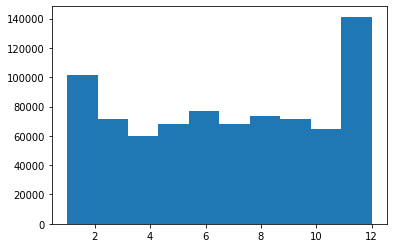

In [18]:
plt.hist(year_data8['Month'].compute())

(array([ 69371.,  85790., 120414.,  76890.,      0.,  54652.,  48434.,
         12817.,  15533.,   3005.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

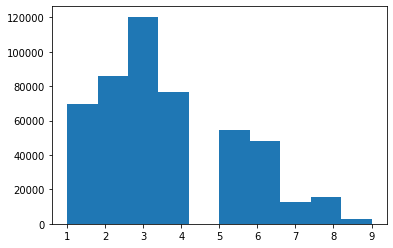

In [19]:
plt.hist(year_data7['Month'].compute())

(array([101228.,  71227.,  60242.,  67780.,  76880.,  67829.,  73227.,
         71447.,  64979., 141300.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

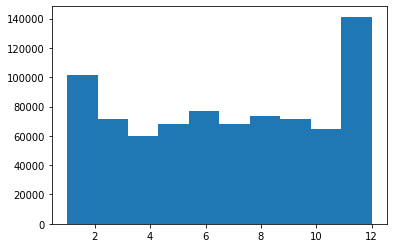

In [ ]:
plt.hist(year_data['Month'].compute())

(array([105842.,  73101.,  68173.,  83537.,  79906.,  90144.,  96428.,
         84770.,  91495., 190829.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

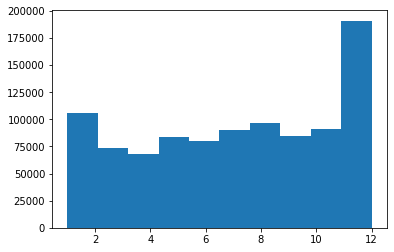

In [ ]:
plt.hist(year_data2['Month'].compute())

(array([ 79241.,  52104.,  52874.,  52762.,  63492.,  68123.,  62159.,
         58153.,  59333., 114478.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

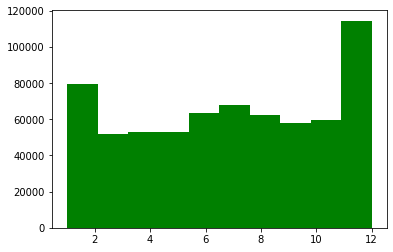

In [ ]:
plt.hist(year_data3['Month'].compute(),color='g')

(array([126103.,  74268.,  70435.,  80297.,  92685.,  99878.,  91095.,
         89882.,  99039., 185376.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

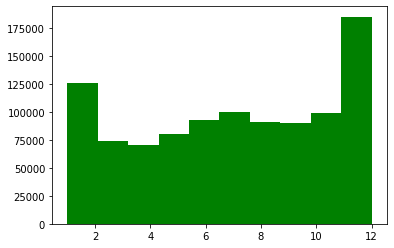

In [ ]:
plt.hist(year_data4['Month'].compute(),color = 'g')

(array([137373.,  81990.,  74778.,  81504.,  85197.,  89106.,  93524.,
         83014.,  91208., 178667.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

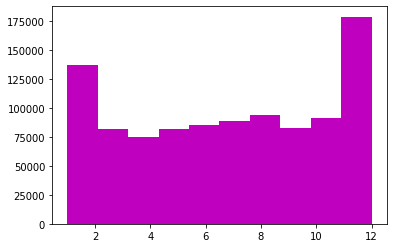

In [ ]:
plt.hist(year_data5['Month'].compute(),color = 'm')

(array([138112.,  71622.,  30388.,  37378.,  55690.,  65479.,  66473.,
         74034.,  89290., 179642.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

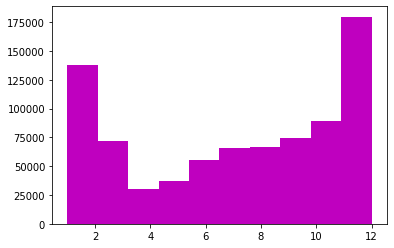

In [ ]:
plt.hist(year_data6['Month'].compute(),color = 'm')

(array([ 69371.,  85790., 120414.,  76890.,      0.,  54652.,  48434.,
         12817.,  15533.,   3005.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

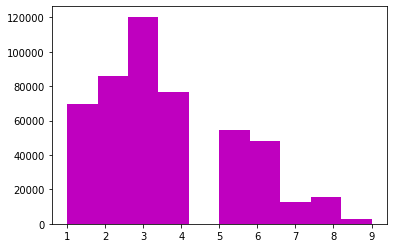

In [ ]:
plt.hist(year_data7['Month'].compute(),color = 'm')

In [ ]:
file['PPD_Category_Type']

Dask Series Structure:
npartitions=73
    object
       ...
     ...  
       ...
       ...
Name: PPD_Category_Type, dtype: object
Dask Name: getitem, 1095 tasks

Visualizing trend in sales based on the property type

(array([1080808.,  688161.,  618708.,  669495.,  712570.,  737296.,
         734932.,  667202.,  698067., 1370917.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

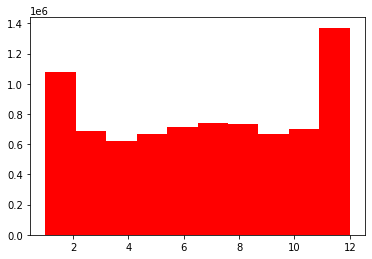

In [ ]:
plt.hist(file[file['Property_Type']== 'T']['Month_of_Transfer'].compute(),color= 'r')


(array([ 949643.,  602111.,  555317.,  612737.,  655984.,  682687.,
         687576.,  614576.,  643007., 1256904.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

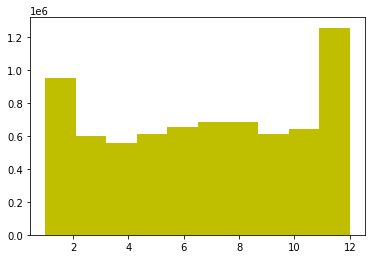

In [ ]:
plt.hist(file[file['Property_Type']== 'S']['Month_of_Transfer'].compute(),color= 'y')

(array([ 764651.,  492735.,  454534.,  500205.,  567470.,  576711.,
         594215.,  529439.,  546173., 1077186.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

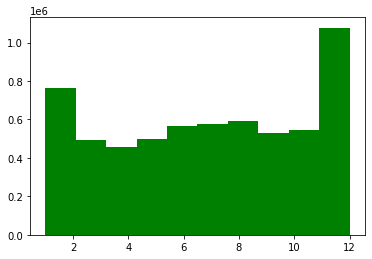

In [ ]:
plt.hist(file[file['Property_Type']== 'D']['Month_of_Transfer'].compute(),color= 'g')

(array([651363., 418956., 357521., 387092., 434395., 427593., 424476.,
        402458., 412466., 830030.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

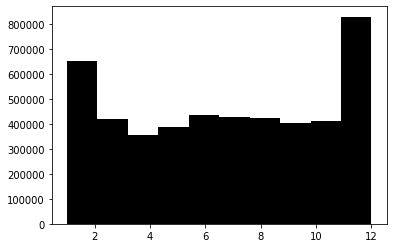

In [ ]:
plt.hist(file[file['Property_Type']== 'F']['Month_of_Transfer'].compute(),color= 'k')

(array([49451., 33725., 25242., 24935., 27068., 26669., 26721., 28149.,
        29450., 60797.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

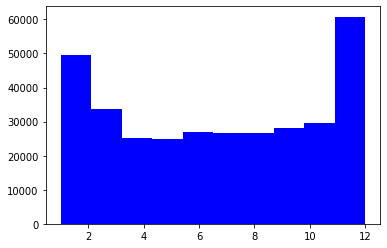

In [ ]:
plt.hist(file[file['Property_Type']== 'O']['Month_of_Transfer'].compute(),color= 'b')